In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
from torchviz import make_dot
from tqdm import tqdm
import wandb

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)# cudaが利用可能だと0

cuda:0


In [11]:
wandb.init(project="mnist_test")
wandb.config = {
  "learning_rate": 0.01,
  "epochs": 100,
  "batch_size": 128
}

In [12]:
# 最終的なデータセットの定義
data_root = './data'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x: x.view(-1)),
])
train_set = datasets.MNIST(
    root = data_root, train=True, download=False, transform=transform
)
test_set = datasets.MNIST(
    root = data_root, train=False, download=False, transform=transform
)

In [13]:
from torch.utils.data import DataLoader
batch_size = wandb.config["batch_size"]

train_loader = DataLoader(
    train_set, batch_size = batch_size,
    shuffle = True
)
test_loader = DataLoader(
    test_set, batch_size = batch_size,
    shuffle = False
)

In [14]:
# 入出力、隠れ層の設定
image, label = train_set[0]
n_input = image.shape[0]
for images, labels in train_loader:
    break
n_output = len(set(list(labels.data.numpy())))
n_hidden = 128

In [15]:
# モデルの定義
# 784入力10出力２隠れ層のNNモデル
class Net2(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()
        # 隠れ層1
        self.l1 = nn.Linear(n_input, n_hidden)
        # 隠れ層2
        self.l2 = nn.Linear(n_hidden, n_hidden)
        # 出力層
        self.l3 = nn.Linear(n_hidden, n_output)
        # ReLU
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        x4 = self.relu(x3)
        x5 = self.l3(x4)
        return x5

In [16]:
# NN層の定義
torch.manual_seed(123)
torch.cuda.manual_seed(123)

# 学習率
lr = wandb.config["learning_rate"]
# モデル初期化
net = Net2(n_input, n_output, n_hidden).to(device)
print(net)
# 損失関数：交差エントロピー関数
criterion = nn.CrossEntropyLoss()
# 最適化関数
optimizer = optim.SGD(net.parameters(), lr=lr)
# 繰り返し回数
num_epochs = wandb.config["epochs"]
# 評価関数結果記録用
history = np.zeros((0,5))

Net2(
  (l1): Linear(in_features=784, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=128, bias=True)
  (l3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [17]:
# 繰り返し計算メインループ
for epoch in range(num_epochs):
    train_acc, train_loss = 0, 0
    test_acc, test_loss = 0, 0
    n_train, n_test = 0, 0

    # 訓練フェーズ
    for inputs, labels in tqdm(train_loader):
        n_train += len(labels)
        # GPUへ転送
        inputs = inputs.to(device)
        labels = labels.to(device)
        # 勾配の初期化
        optimizer.zero_grad()
        # 予測計算
        outputs = net(inputs)
        # 損失計算
        loss = criterion(outputs, labels)
        # 勾配計算
        loss.backward()
        # パラメータ修正
        optimizer.step()
        # 予測ラベル導出
        predicted = torch.max(outputs, 1)[1]
        # 損失と精度の計算
        train_loss += loss.item()
        train_acc += (predicted == labels).sum().item() 

    # 予測フェーズ
    for inputs_test, labels_test in test_loader:
        n_test += len(labels_test)
        inputs_test = inputs_test.to(device)
        labels_test = labels_test.to(device)

        # 予測計算
        outputs_test = net(inputs_test)

        # 損失関数
        loss_test = criterion(outputs_test, labels_test)


        # 予測データ導出
        predicted_test = torch.max(outputs_test, 1)[1]

        # 損失と制度の計算
        test_loss += loss_test.item()
        test_acc += (predicted_test == labels_test).sum().item()

    # 評価値の算出・記録
    train_acc = train_acc / n_train
    test_acc = test_acc / n_test
    train_loss = train_loss * batch_size / n_train
    test_loss = test_loss * batch_size / n_test
    print (f'Epoch [{epoch+1}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {test_loss:.5f}, val_acc: {test_acc:.5f}')
    item = np.array([epoch+1 , train_loss, train_acc, test_loss, test_acc])
    history = np.vstack((history, item))
    wandb.log({"epoch": epoch, "train_loss": train_loss, "test_loss": test_loss})
print(f'初期状態：損失：{history[0,3]:.5f}  精度：{history[0,4]:.5f}')
print(f'最終状態：損失：{history[-1,3]:.5f}  精度：{history[-1,4]:.5f}')

100%|██████████| 469/469 [00:02<00:00, 172.28it/s]


Epoch [1/100], loss: 1.47992 acc: 0.59645 val_loss: 0.66472, val_acc: 0.83550


100%|██████████| 469/469 [00:02<00:00, 203.43it/s]


Epoch [2/100], loss: 0.50794 acc: 0.86490 val_loss: 0.40550, val_acc: 0.88480


 80%|███████▉  | 375/469 [00:01<00:00, 201.56it/s]


KeyboardInterrupt: 

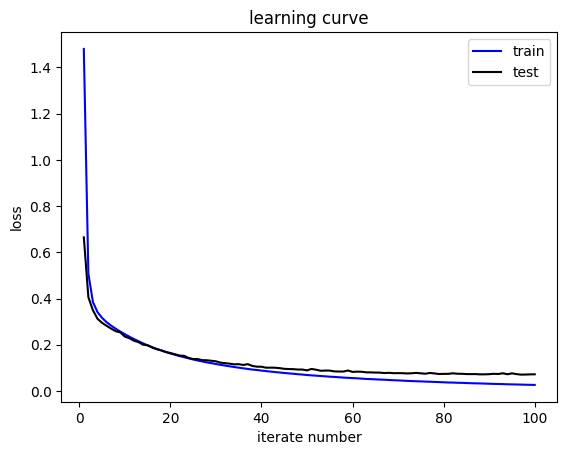

In [ ]:
# 学習曲線の表示(損失)
plt.plot(history[:,0], history[:,1], "b", label="train")
plt.plot(history[:,0], history[:,3], "k", label="test")
plt.xlabel('iterate number')
plt.ylabel('loss')
plt.title('learning curve')
plt.legend()
plt.show()

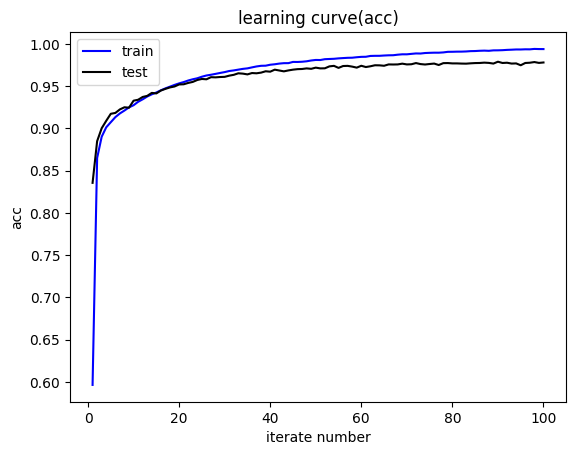

In [ ]:
# 学習曲線の表示(精度)
plt.plot(history[:,0], history[:,2], "b", label="train")
plt.plot(history[:,0], history[:,4], "k", label="test")
plt.xlabel('iterate number')
plt.ylabel('acc')
plt.title('learning curve(acc)')
plt.legend()
plt.show()